# Part 1 - Write a colab to demonstrate supervised contrastive learning loss based supervised classification versus regular softmax based one

In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 11.9 MB/s 


In [ ]:
%load_ext autoreload
%autoreload 2
import datetime
import numpy as np
import tensorflow as tf
print(tf.__version__)
import tensorflow_addons as tfa

import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

2.8.0


## Write helper functions - Model and Losses for preprocessing task

In [ ]:
%%writefile model.py

import tensorflow as tf


class UnitNormLayer(tf.keras.layers.Layer):
    '''Normalize vectors (euclidean norm) in batch to unit hypersphere.
    '''

    def __init__(self):
        super(UnitNormLayer, self).__init__()

    def call(self, input_tensor):
        norm = tf.norm(input_tensor, axis=1)
        return input_tensor / tf.reshape(norm, [-1, 1])


class DenseLeakyReluLayer(tf.keras.layers.Layer):
    '''A dense layer followed by a LeakyRelu layer
    '''

    def __init__(self, n, alpha=0.3):
        super(DenseLeakyReluLayer, self).__init__()
        self.dense = tf.keras.layers.Dense(n, activation=None)
        self.lrelu = tf.keras.layers.LeakyReLU(alpha=alpha)

    def call(self, input_tensor):
        x = self.dense(input_tensor)
        return self.lrelu(x)


class Encoder(tf.keras.Model):
    '''An encoder network, E(·), which maps an augmented image x to a representation vector, r = E(x) ∈ R^{DE}
    '''

    def __init__(self, normalize=True, activation='relu'):
        super(Encoder, self).__init__(name='')
        if activation == 'leaky_relu':
            self.hidden1 = DenseLeakyReluLayer(256)
            self.hidden2 = DenseLeakyReluLayer(256)
        else:
            self.hidden1 = tf.keras.layers.Dense(256, activation=activation)
            self.hidden2 = tf.keras.layers.Dense(256, activation=activation)

        self.normalize = normalize
        if self.normalize:
            self.norm = UnitNormLayer()

    def call(self, input_tensor, training=False):
        x = self.hidden1(input_tensor, training=training)
        x = self.hidden2(x, training=training)
        if self.normalize:
            x = self.norm(x)
        return x


class Projector(tf.keras.Model):
    '''
    A projection network, P(·), which maps the normalized representation vector r into a vector z = P(r) ∈ R^{DP} 
    suitable for computation of the contrastive loss.
    '''

    def __init__(self, n, normalize=True, activation='relu'):
        super(Projector, self).__init__(name='')
        if activation == 'leaky_relu':
            self.dense = DenseLeakyReluLayer(256)
            self.dense2 = DenseLeakyReluLayer(256)
        else:
            self.dense = tf.keras.layers.Dense(256, activation=activation)
            self.dense2 = tf.keras.layers.Dense(256, activation=activation)

        self.normalize = normalize
        if self.normalize:
            self.norm = UnitNormLayer()

    def call(self, input_tensor, training=False):
        x = self.dense(input_tensor, training=training)
        x = self.dense2(x, training=training)
        if self.normalize:
            x = self.norm(x)
        return x


class SoftmaxPred(tf.keras.Model):
    '''For stage 2, simply a softmax on top of the Encoder.
    '''

    def __init__(self, num_classes=10):
        super(SoftmaxPred, self).__init__(name='')
        self.dense = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, input_tensor, training=False):
        return self.dense(input_tensor, training=training)


class MLP(tf.keras.Model):
    '''A simple baseline MLP with the same architecture to Encoder + Softmax/Regression output.
    '''

    def __init__(self, num_classes=10, normalize=True, regress=False, activation='relu'):
        super(MLP, self).__init__(name='')
        if activation == 'leaky_relu':
            self.hidden1 = DenseLeakyReluLayer(256)
            self.hidden2 = DenseLeakyReluLayer(256)
        else:
            self.hidden1 = tf.keras.layers.Dense(256, activation=activation)
            self.hidden2 = tf.keras.layers.Dense(256, activation=activation)
        self.normalize = normalize
        if self.normalize:
            self.norm = UnitNormLayer()
        if not regress:
            self.output_layer = tf.keras.layers.Dense(
                num_classes, activation='softmax')
        else:
            self.output_layer = tf.keras.layers.Dense(1)

    def call(self, input_tensor, training=False):
        x = self.hidden1(input_tensor, training=training)
        x = self.hidden2(x, training=training)
        if self.normalize:
            x = self.norm(x)
        preds = self.output_layer(x, training=training)
        return preds

    def get_last_hidden(self, input_tensor):
        '''Get the last hidden layer before prediction.
        '''
        x = self.hidden1(input_tensor, training=False)
        x = self.hidden2(x, training=False)
        if self.normalize:
            x = self.norm(x)
        return x

Writing model.py


In [ ]:
%%writefile losses.py

import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa


def pdist_euclidean(A):
    # Euclidean pdist
    # https://stackoverflow.com/questions/37009647/compute-pairwise-distance-in-a-batch-without-replicating-tensor-in-tensorflow
    r = tf.reduce_sum(A*A, 1)

    # turn r into column vector
    r = tf.reshape(r, [-1, 1])
    D = r - 2*tf.matmul(A, tf.transpose(A)) + tf.transpose(r)
    return tf.sqrt(D)


def square_to_vec(D):
    '''Convert a squared form pdist matrix to vector form.
    '''
    n = D.shape[0]
    triu_idx = np.triu_indices(n, k=1)
    d_vec = tf.gather_nd(D, list(zip(triu_idx[0], triu_idx[1])))
    return d_vec


def get_contrast_batch_labels(y):
    '''
    Make contrast labels by taking all the pairwise in y
    y: tensor with shape: (batch_size, )
    returns:   
        tensor with shape: (batch_size * (batch_size-1) // 2, )
    '''
    y_col_vec = tf.reshape(tf.cast(y, tf.float32), [-1, 1])
    D_y = pdist_euclidean(y_col_vec)
    d_y = square_to_vec(D_y)
    y_contrasts = tf.cast(d_y == 0, tf.int32)
    return y_contrasts


def get_contrast_batch_labels_regression(y):
    '''
    Make contrast labels for regression by taking all the pairwise in y
    y: tensor with shape: (batch_size, )
    returns:   
        tensor with shape: (batch_size * (batch_size-1) // 2, )
    '''
    raise NotImplementedError


def max_margin_contrastive_loss(z, y, margin=1.0, metric='euclidean'):
    '''
    Wrapper for the maximum margin contrastive loss (Hadsell et al. 2006)
    `tfa.losses.contrastive_loss`
    Args:
        z: hidden vector of shape [bsz, n_features].
        y: ground truth of shape [bsz].
        metric: one of ('euclidean', 'cosine')
    '''
    # compute pair-wise distance matrix
    if metric == 'euclidean':
        D = pdist_euclidean(z)
    elif metric == 'cosine':
        D = 1 - tf.matmul(z, z, transpose_a=False, transpose_b=True)
    # convert squareform matrix to vector form
    d_vec = square_to_vec(D)
    # make contrastive labels
    y_contrasts = get_contrast_batch_labels(y)
    loss = tfa.losses.contrastive_loss(y_contrasts, d_vec, margin=margin)
    # exploding/varnishing gradients on large batch?
    return tf.reduce_mean(loss)


def multiclass_npairs_loss(z, y):
    '''
    Wrapper for the multiclass N-pair loss (Sohn 2016)
    `tfa.losses.npairs_loss`
    Args:
        z: hidden vector of shape [bsz, n_features].
        y: ground truth of shape [bsz].
    '''
    # cosine similarity matrix
    S = tf.matmul(z, z, transpose_a=False, transpose_b=True)
    loss = tfa.losses.npairs_loss(y, S)
    return loss


def triplet_loss(z, y, margin=1.0, kind='hard'):
    '''
    Wrapper for the triplet losses 
    `tfa.losses.triplet_hard_loss` and `tfa.losses.triplet_semihard_loss`
    Args:
        z: hidden vector of shape [bsz, n_features], assumes it is l2-normalized.
        y: ground truth of shape [bsz].    
    '''
    if kind == 'hard':
        loss = tfa.losses.triplet_hard_loss(y, z, margin=margin, soft=False)
    elif kind == 'soft':
        loss = tfa.losses.triplet_hard_loss(y, z, margin=margin, soft=True)
    elif kind == 'semihard':
        loss = tfa.losses.triplet_semihard_loss(y, z, margin=margin)
    return loss


def supervised_nt_xent_loss(z, y, temperature=0.5, base_temperature=0.07):
    '''
    Supervised normalized temperature-scaled cross entropy loss. 
    A variant of Multi-class N-pair Loss from (Sohn 2016)
    Later used in SimCLR (Chen et al. 2020, Khosla et al. 2020).
    Implementation modified from: 
        - https://github.com/google-research/simclr/blob/master/objective.py
        - https://github.com/HobbitLong/SupContrast/blob/master/losses.py
    Args:
        z: hidden vector of shape [bsz, n_features].
        y: ground truth of shape [bsz].
    '''
    batch_size = tf.shape(z)[0]
    contrast_count = 1
    anchor_count = contrast_count
    y = tf.expand_dims(y, -1)

    # mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
    #     has the same class as sample i. Can be asymmetric.
    mask = tf.cast(tf.equal(y, tf.transpose(y)), tf.float32)
    anchor_dot_contrast = tf.divide(
        tf.matmul(z, tf.transpose(z)),
        temperature
    )
    # # for numerical stability
    logits_max = tf.reduce_max(anchor_dot_contrast, axis=1, keepdims=True)
    logits = anchor_dot_contrast - logits_max
    # # tile mask
    logits_mask = tf.ones_like(mask) - tf.eye(batch_size)
    mask = mask * logits_mask
    # compute log_prob
    exp_logits = tf.exp(logits) * logits_mask
    log_prob = logits - \
        tf.math.log(tf.reduce_sum(exp_logits, axis=1, keepdims=True))

    # compute mean of log-likelihood over positive
    # this may introduce NaNs due to zero division,
    # when a class only has one example in the batch
    mask_sum = tf.reduce_sum(mask, axis=1)
    mean_log_prob_pos = tf.reduce_sum(
        mask * log_prob, axis=1)[mask_sum > 0] / mask_sum[mask_sum > 0]

    # loss
    loss = -(temperature / base_temperature) * mean_log_prob_pos
    # loss = tf.reduce_mean(tf.reshape(loss, [anchor_count, batch_size]))
    loss = tf.reduce_mean(loss)
    return loss

Writing losses.py


In [ ]:
%load_ext autoreload
%autoreload 2
#from contrast_loss_utils import *
from model import *
import losses

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# global configs
EPOCHS = 20
DATA = 'mnist-regression'
NORMALIZE_EMBEDDING = True
# NORMALIZE_EMBEDDING = False
N_DATA_TRAIN = 60000
# N_DATA_TRAIN = 10000
BATCH_SIZE = 32
PROJECTION_DIM = 128
WRITE_SUMMARY = False
ACTIVATION = 'leaky_relu'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
!mkdir -p logs/

In [ ]:
optimizer = tf.keras.optimizers.Adam()

## Load MNIST data

In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)
print(x_train.shape, x_test.shape)

11501568/11490434 [==============================] - 0s 0us/step
(60000, 784) (10000, 784)


In [ ]:
# simulate low data regime for training
n_train = x_train.shape[0]
shuffle_idx = np.arange(n_train)
np.random.shuffle(shuffle_idx)

x_train = x_train[shuffle_idx][:N_DATA_TRAIN]
y_train = y_train[shuffle_idx][:N_DATA_TRAIN]
print(x_train.shape, y_train.shape)

(60000, 784) (60000,)


In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(5000).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

## Train baseline model

In [ ]:
mlp = MLP(normalize=NORMALIZE_EMBEDDING, activation=ACTIVATION)
cce_loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_ACC')

In [ ]:
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_ACC')

In [ ]:
@tf.function
def train_step_baseline(x, y):
    with tf.GradientTape() as tape:
        y_preds = mlp(x, training=True)
        loss = cce_loss_obj(y, y_preds)

    gradients = tape.gradient(loss, 
                              mlp.trainable_variables)
    optimizer.apply_gradients(zip(gradients, 
                                  mlp.trainable_variables))

    train_loss(loss)
    train_acc(y, y_preds)

In [ ]:
@tf.function
def test_step_baseline(x, y):
    y_preds = mlp(x, training=False)
    t_loss = cce_loss_obj(y, y_preds)
    test_loss(t_loss)
    test_acc(y, y_preds)

In [ ]:
model_name = 'baseline'
if not NORMALIZE_EMBEDDING:
    model_name = 'baseline-no_norm'

if WRITE_SUMMARY:
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_dir = 'logs/%s/%s/%s/train' % (model_name, DATA, current_time)
    test_log_dir = 'logs/%s/%s/%s/test' % (model_name, DATA, current_time)
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    test_summary_writer = tf.summary.create_file_writer(test_log_dir)


In [ ]:
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()

    for x, y in train_ds:
        train_step_baseline(x, y)
        
    if WRITE_SUMMARY:
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', train_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', train_acc.result(), step=epoch)        

    for x_te, y_te in test_ds:
        test_step_baseline(x_te, y_te)

    if WRITE_SUMMARY:
        with test_summary_writer.as_default():
            tf.summary.scalar('loss', test_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', test_acc.result(), step=epoch)        

    template = 'Epoch {}, Loss: {}, Acc: {}, Test Loss: {}, Test Acc: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_acc.result() * 100,
                        test_loss.result(),
                        test_acc.result() * 100))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Epoch 1, Loss: 0.3615182340145111, Acc: 92.53666687011719, Test Loss: 0.1547420769929886, Test Acc: 95.51000213623047
Epoch 2, Loss: 0.13029441237449646, Acc: 96.22000122070312, Test Loss: 0.11337932199239731, Test Acc: 96.49000549316406
Epoch 3, Loss: 0.09352532774209976, Acc: 97.19332885742188, Test Loss: 0.10019632428884506, Test Acc: 96.73999786376953
Epoch 4, Loss: 0.07398301362991333, Acc: 97.76499938964844, Test Loss: 0.09287609159946442, Test Acc: 97.0199966430664
Epoch 5, Loss: 0.0610775426030159, Acc: 98.12166595458984, Test Loss: 0.09481105953454971, Test Acc: 96.97999572753906
Epoch 6, Loss: 0.052302390336990356, Acc: 98.41500091552734, Test Loss: 0.08915296941995621, Test Acc: 97.16999816894531
Epoch 7, Loss: 0.0467526838183403, Acc: 98.52166748046875, Test Loss: 0.07854151725769043, Test Acc: 97.55999755859375
Epoch 8, Loss: 0.040342822670936584, Acc: 98.7699966430664, Test Loss: 0.0853121429681778, Test Acc: 97.41999816894531
Epoch 9, Loss: 0.034639872610569, Acc: 98.936

In [ ]:
# get the projections from the last hidden layer before output
x_tr_proj = mlp.get_last_hidden(x_train)
x_tr_proj.shape

TensorShape([60000, 256])

In [ ]:
x_te_proj = mlp.get_last_hidden(x_test)
x_te_proj.shape

TensorShape([10000, 256])

In [ ]:
# convert tensor to np.array
x_tr_proj = x_tr_proj.numpy()
x_te_proj = x_te_proj.numpy()
print(x_tr_proj.shape, x_te_proj.shape)

(60000, 256) (10000, 256)


### 1.2. Check learned embedding

In [ ]:
# do PCA for the projected data
pca = PCA(n_components=2)
pca.fit(x_tr_proj)

PCA(n_components=2)

In [ ]:
x_te_proj_pca = pca.transform(x_te_proj)
x_te_proj_pca.shape

(10000, 2)

In [ ]:
x_te_proj_pca_df = pd.DataFrame(x_te_proj_pca, columns=['PC1', 'PC2'])
x_te_proj_pca_df['label'] = y_test

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


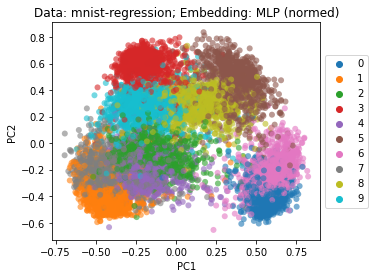

In [ ]:
fig, ax = plt.subplots()
ax = sns.scatterplot('PC1', 'PC2', 
                     data=x_te_proj_pca_df,
                     palette='tab10',
                     hue='label',
                     linewidth=0,
                     alpha=0.6,
                     ax=ax
                    )

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
title = 'Data: %s; Embedding: MLP'% DATA
if NORMALIZE_EMBEDDING:
    title = 'Data: %s; Embedding: MLP (normed)'% DATA
ax.set_title(title);

#fig.savefig('/figs/PCA_plot_%s_MLP_last_layer.png' % DATA)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


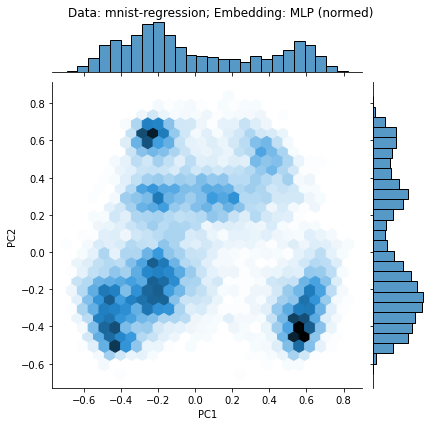

In [ ]:
g = sns.jointplot('PC1', 'PC2', data=x_te_proj_pca_df,
              kind="hex"
             )
plt.subplots_adjust(top=0.95)
g.fig.suptitle(title);
#g.savefig('figs/Joint_PCA_plot_%s_MLP_last_layer.png' % DATA)

## Stage 1: train encoder with contrastive loss

In [ ]:
encoder = Encoder(normalize=NORMALIZE_EMBEDDING, activation=ACTIVATION)
projector = Projector(PROJECTION_DIM, normalize=NORMALIZE_EMBEDDING, activation=ACTIVATION)


In [ ]:
# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_mae = tf.keras.metrics.MeanAbsoluteError(name='train_contrast_MAE')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_mae = tf.keras.metrics.MeanAbsoluteError(name='test_contrast_MAE')


In [ ]:
@tf.function
# train step for the contrast loss
def train_step_contrast(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:
        r = encoder(x, training=True)
        z = projector(r, training=True)
        loss = losses.max_margin_contrastive_loss(z, y, metric='cosine')

    gradients = tape.gradient(loss, 
                              encoder.trainable_variables + projector.trainable_variables)
    optimizer.apply_gradients(zip(gradients, 
                                  encoder.trainable_variables + projector.trainable_variables))

    train_loss(loss)

In [ ]:
@tf.function
def test_step_contrast(x, y):
    r = encoder(x, training=False)
    z = projector(r, training=False)
    t_loss = losses.max_margin_contrastive_loss(z, y, metric='cosine')
    test_loss(t_loss)

In [ ]:
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
 #   train_bce.reset_states()
    test_loss.reset_states()
 #   test_bce.reset_states()

    for x, y in train_ds:
        train_step_contrast(x, y)

    for x_te, y_te in test_ds:
        test_step_contrast(x_te, y_te)

    template = 'Epoch {}, Loss: {}, Test Loss: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
#                         train_bce.result(),
                        test_loss.result(),
#                         test_bce.result()
                         ))


Epoch 1, Loss: 0.02365943230688572, Test Loss: 0.013089247047901154
Epoch 2, Loss: 0.012479915283620358, Test Loss: 0.011639606207609177
Epoch 3, Loss: 0.009893335402011871, Test Loss: 0.008422416634857655
Epoch 4, Loss: 0.008282661437988281, Test Loss: 0.008470016531646252
Epoch 5, Loss: 0.0069745550863444805, Test Loss: 0.0081106498837471
Epoch 6, Loss: 0.006434137932956219, Test Loss: 0.008406993001699448
Epoch 7, Loss: 0.005603281315416098, Test Loss: 0.007923202589154243
Epoch 8, Loss: 0.004938211757689714, Test Loss: 0.007830213755369186
Epoch 9, Loss: 0.004454907029867172, Test Loss: 0.007781487423926592
Epoch 10, Loss: 0.004242302849888802, Test Loss: 0.006117843557149172
Epoch 11, Loss: 0.003732929239049554, Test Loss: 0.007636795286089182
Epoch 12, Loss: 0.0034857268910855055, Test Loss: 0.006857299245893955
Epoch 13, Loss: 0.0031168528366833925, Test Loss: 0.0063261413015425205
Epoch 14, Loss: 0.0029801519121974707, Test Loss: 0.005914646200835705
Epoch 15, Loss: 0.002778984

In [ ]:
x_tr_proj = projector(encoder(x_train))
x_tr_proj.shape

TensorShape([60000, 256])

In [ ]:
x_te_proj = projector(encoder(x_test))
x_te_proj.shape

TensorShape([10000, 256])

In [ ]:
# convert tensor to np.array
x_tr_proj = x_tr_proj.numpy()
x_te_proj = x_te_proj.numpy()
print(x_tr_proj.shape, x_te_proj.shape)

(60000, 256) (10000, 256)


## Check learned embedding

In [ ]:
from sklearn.decomposition import PCA
# do PCA for the projected data


pca = PCA(n_components=2)
pca.fit(x_tr_proj)
x_te_proj_pca = pca.transform(x_te_proj)
x_te_proj_pca.shape

(10000, 2)

In [ ]:
# do PCA for original data
pca = PCA(n_components=2)
pca.fit(x_train)
x_te_pca = pca.transform(x_test)
x_te_pca.shape

(10000, 2)

In [ ]:
x_te_proj_df = pd.DataFrame(x_te_proj[:, :2], columns=['Proj1', 'Proj2'])
x_te_proj_df['label'] = y_test

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


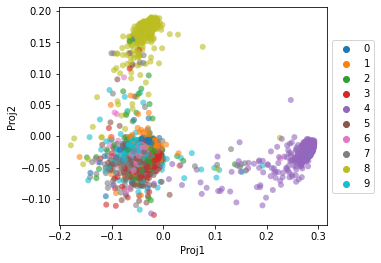

In [ ]:
# x_te_proj_df.head()
ax = sns.scatterplot('Proj1', 'Proj2', data=x_te_proj_df,
                palette='tab10',
                hue='label',
                linewidth=0,
                alpha=0.6
               )
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


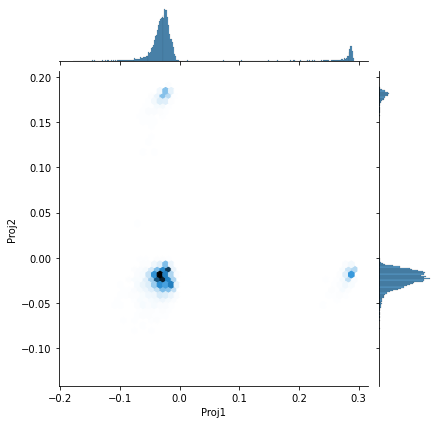

In [ ]:
sns.jointplot('Proj1', 'Proj2', data=x_te_proj_df,
              kind="hex"
             );



In [ ]:
x_te_proj_pca_df = pd.DataFrame(x_te_proj_pca, columns=['PC1', 'PC2'])
x_te_proj_pca_df['label'] = y_test


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


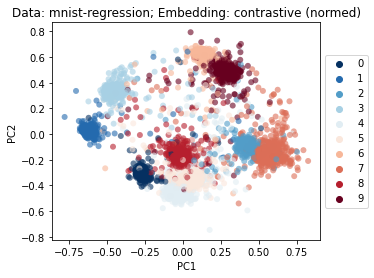

In [ ]:
ax = sns.scatterplot('PC1', 'PC2', data=x_te_proj_pca_df,
#                 palette='tab10',
                     palette='RdBu_r',
                     legend='full',
                hue='label',
                linewidth=0,
                alpha=0.6
               );

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
title = 'Data: %s; Embedding: contrastive'% DATA
if NORMALIZE_EMBEDDING:
    title = 'Data: %s; Embedding: contrastive (normed)'% DATA
ax.set_title(title);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


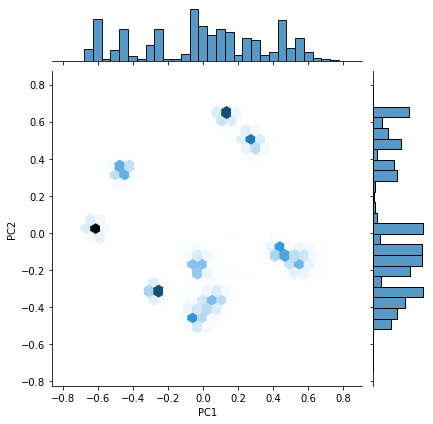

In [ ]:
sns.jointplot('PC1', 'PC2', data=x_te_proj_pca_df,
              kind="hex"
             )

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


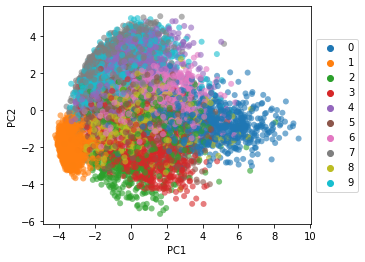

In [ ]:
x_te_pca_df = pd.DataFrame(x_te_pca, columns=['PC1', 'PC2'])
x_te_pca_df['label'] = y_test

ax = sns.scatterplot('PC1', 'PC2', data=x_te_pca_df,
                palette='tab10',
                hue='label',
                linewidth=0,
                alpha=0.6
               )
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


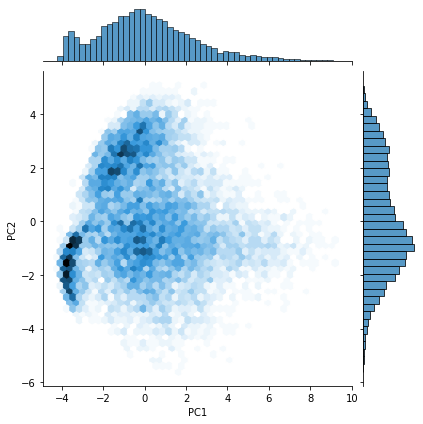

In [ ]:
sns.jointplot('PC1', 'PC2', data=x_te_pca_df,
              kind="hex"
             );

## Stage 2: Freeze the learned representations and then learn a classifier on a linear layer using a softmax loss

In [ ]:
softmax = SoftmaxPred()
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_ACC')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_ACC')

cce_loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

@tf.function
# train step for the 2nd stage
def train_step(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:        
        r = encoder(x, training=False)
        y_preds = softmax(r, training=True)
        loss = cce_loss_obj(y, y_preds)

    # freeze the encoder, only train the softmax layer
    gradients = tape.gradient(loss, 
                              softmax.trainable_variables) 
    optimizer.apply_gradients(zip(gradients, 
                                  softmax.trainable_variables))

    train_loss(loss)
    train_acc(y, y_preds)


In [ ]:
@tf.function
def test_step(x, y):
    r = encoder(x, training=False)
    y_preds = softmax(r, training=False)

    t_loss = cce_loss_obj(y, y_preds)

    test_loss(t_loss)
    test_acc(y, y_preds)
model_name = 'contrast_loss_model'
if not NORMALIZE_EMBEDDING:
    model_name = 'contrast_loss_model-no_norm'
if WRITE_SUMMARY:
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_dir = 'logs/%s/%s/%s/train' % (model_name, DATA, current_time)
    test_log_dir = 'logs/%s/%s/%s/test' % (model_name, DATA, current_time)
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    test_summary_writer = tf.summary.create_file_writer(test_log_dir)


In [ ]:
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()

    for x, y in train_ds:
        train_step(x, y)

    if WRITE_SUMMARY:
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', train_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', train_acc.result(), step=epoch)        
        
    for x_te, y_te in test_ds:
        test_step(x_te, y_te)

    if WRITE_SUMMARY:
        with test_summary_writer.as_default():
            tf.summary.scalar('loss', test_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', test_acc.result(), step=epoch)        
        
    template = 'Epoch {}, Loss: {}, Acc: {}, Test Loss: {}, Test Acc: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_acc.result() * 100,
                        test_loss.result(),
                        test_acc.result() * 100))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Epoch 1, Loss: 0.22691212594509125, Acc: 97.5683364868164, Test Loss: 0.11570162326097488, Test Acc: 97.15999603271484
Epoch 2, Loss: 0.06957167387008667, Acc: 98.7750015258789, Test Loss: 0.08705989271402359, Test Acc: 97.6199951171875
Epoch 3, Loss: 0.047599032521247864, Acc: 99.14500427246094, Test Loss: 0.07585526257753372, Test Acc: 97.82999420166016
Epoch 4, Loss: 0.037084802985191345, Acc: 99.31999969482422, Test Loss: 0.06985567510128021, Test Acc: 97.93000030517578
Epoch 5, Loss: 0.03100637160241604, Acc: 99.45999908447266, Test Loss: 0.06636834889650345, Test Acc: 98.0
Epoch 6, Loss: 0.02709844708442688, Acc: 99.55000305175781, Test Loss: 0.06406718492507935, Test Acc: 98.06999969482422
Epoch 7, Loss: 0.024389861151576042, Acc: 99.61666107177734, Test Loss: 0.06250007450580597, Test Acc: 98.11000061035156
Epoch 8, Loss: 0.022386379539966583, Acc: 99.65499877929688, Test Loss: 0.06153295561671257, Test Acc: 98.11000061035156
Epoch 9, Loss: 0.02086460590362549, Acc: 99.67832946

In [ ]:
test_acc.result().numpy() # default max margin contrastive loss

0.9833

In [ ]:
test_acc.result().numpy() # max margin contrastive loss (cosine)

0.9833

# Second Example - Supervised Contrastive Learning

## SET UP

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

## PREPARE THE DATA

In [ ]:
num_classes = 10
input_shape = (32, 32, 3)

# Load the train and test data splits
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Display shapes of train and test datasets
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

170508288/170498071 [==============================] - 6s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## Using image data augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.02),
        layers.RandomWidth(0.2),
        layers.RandomHeight(0.2),
    ]
)

# Setting the state of the normalization layer.
data_augmentation.layers[0].adapt(x_train)

## Build the encoder model
The encoder model takes the image as input and turns it into a 2048-dimensional feature vector.

In [ ]:
def create_encoder():
    resnet = keras.applications.ResNet50V2(
        include_top=False, weights=None, input_shape=input_shape, pooling="avg"
    )

    inputs = keras.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    outputs = resnet(augmented)
    model = keras.Model(inputs=inputs, outputs=outputs, name="cifar10-encoder")
    return model


encoder = create_encoder()
encoder.summary()

learning_rate = 0.001
batch_size = 265
hidden_units = 512
projection_units = 128
num_epochs = 50
dropout_rate = 0.5
temperature = 0.05

Model: "cifar10-encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 32, 32, 3)         7         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
Total params: 23,564,807
Trainable params: 23,519,360
Non-trainable params: 45,447
_________________________________________________________________


## Build the classification model
The classification model adds a fully-connected layer on top of the encoder, plus a softmax layer with the target classes.



In [ ]:
def create_classifier(encoder, trainable=True):

    for layer in encoder.layers:
        layer.trainable = trainable

    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    features = layers.Dropout(dropout_rate)(features)
    features = layers.Dense(hidden_units, activation="relu")(features)
    features = layers.Dropout(dropout_rate)(features)
    outputs = layers.Dense(num_classes, activation="softmax")(features)

    model = keras.Model(inputs=inputs, outputs=outputs, name="cifar10-classifier")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )
    return model

## Experiment 1: Train the baseline classification model
In this experiment, a baseline classifier is trained as usual, i.e., the encoder and the classifier parts are trained together as a single model to minimize the crossentropy loss.

In [ ]:
encoder = create_encoder()
classifier = create_classifier(encoder)
classifier.summary()

history = classifier.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs)

accuracy = classifier.evaluate(x_test, y_test)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

Model: "cifar10-classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 cifar10-encoder (Functional  (None, 2048)             23564807  
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 10)                5130      
                                                

## Experiment 2: Use supervised contrastive learning
In this experiment, the model is trained in two phases. In the first phase, the encoder is pretrained to optimize the supervised contrastive loss, described in Prannay Khosla et al..

In the second phase, the classifier is trained using the trained encoder with its weights freezed; only the weights of fully-connected layers with the softmax are optimized.

### 1. Supervised contrastive learning loss function

In [ ]:
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)


def add_projection_head(encoder):
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    outputs = layers.Dense(projection_units, activation="relu")(features)
    model = keras.Model(
        inputs=inputs, outputs=outputs, name="cifar-encoder_with_projection-head"
    )
    return model

### 2. Pretrain the encoder

In [ ]:
encoder = create_encoder()

encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)

encoder_with_projection_head.summary()

history = encoder_with_projection_head.fit(
    x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs
)


Model: "cifar-encoder_with_projection-head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 cifar10-encoder (Functional  (None, 2048)             23564807  
 )                                                               
                                                                 
 dense_10 (Dense)            (None, 128)               262272    
                                                                 
Total params: 23,827,079
Trainable params: 23,781,632
Non-trainable params: 45,447
_________________________________________________________________
Epoch 1/50
189/189 [==============================] - 23s 84ms/step - loss: 5.3797
Epoch 2/50
189/189 [==============================] - 16s 84ms/step - loss: 5.1526
Epoch 3/50
189/189 [===========================

### 3. Train the classifier with the frozen encoder

In [ ]:
classifier = create_classifier(encoder, trainable=False)

history = classifier.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs)

accuracy = classifier.evaluate(x_test, y_test)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

Epoch 1/50
189/189 [==============================] - 10s 29ms/step - loss: 0.3663 - sparse_categorical_accuracy: 0.9000
Epoch 2/50
189/189 [==============================] - 5s 28ms/step - loss: 0.3118 - sparse_categorical_accuracy: 0.9076
Epoch 3/50
189/189 [==============================] - 5s 28ms/step - loss: 0.2958 - sparse_categorical_accuracy: 0.9105
Epoch 4/50
189/189 [==============================] - 5s 28ms/step - loss: 0.2878 - sparse_categorical_accuracy: 0.9097
Epoch 5/50
189/189 [==============================] - 5s 29ms/step - loss: 0.2943 - sparse_categorical_accuracy: 0.9095
Epoch 6/50
189/189 [==============================] - 5s 28ms/step - loss: 0.2894 - sparse_categorical_accuracy: 0.9094
Epoch 7/50
189/189 [==============================] - 5s 28ms/step - loss: 0.2880 - sparse_categorical_accuracy: 0.9107
Epoch 8/50
189/189 [==============================] - 5s 28ms/step - loss: 0.2917 - sparse_categorical_accuracy: 0.9096
Epoch 9/50
189/189 [===================

We get to an improved test accuracy.

# **Conclusion**
As shown in the experiments, using the supervised contrastive learning technique outperformed the conventional technique in terms of the test accuracy. Note that the same training budget (i.e., number of epochs) was given to each technique. Supervised contrastive learning pays off when the encoder involves a complex architecture, like ResNet, and multi-class problems with many labels. In addition, large batch sizes and multi-layer projection heads improve its effectiveness.